In [6]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import*

In [7]:
def SO2_from_params(theta):
    return array([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]])

def SE2_from_params(theta, x, y):
    return array([
        [cos(theta), -sin(theta), x],
        [sin(theta), cos(theta), y],
        [0, 0, 1]])

def SE2_to_params(X):
    assert X.shape == (3, 3)
    theta = arctan2(X[1, 0], X[0, 0])
    return array([theta, X[0, 2], X[1, 2]])

def SE2_inv(X):
    theta, x, y = SE2_to_params(X)
    R_T = SO2_from_params(theta).T
    v = -R_T@[x, y]
    return array([
        [R_T[0, 0], R_T[0, 1], v[0]],
        [R_T[1, 0], R_T[1, 1], v[1]],
        [0, 0, 1]])

def SE2_wedge(v):
    assert v.shape == (3,)
    return array([
        [0, -v[0], v[1]],
        [v[0], 0, v[2]],
        [0, 0, 0]])

def SE2_vee(a):
    assert a.shape == (3,3)
    return array([a[1,0], a[0,2], a[1,2]])

def SE2_exp_wedge(a):
    assert a.shape == (3,)
    alpha = a[0]
    u1 = a[1]
    u2 = a[2]
    if alpha < 0.1:
        t1 = 1 - alpha**2/6 + alpha**4/120
        t2 = alpha/2 - alpha**3/24 - alpha**5/720
    else:
        t1 = sin(alpha)/alpha
        t2 = 1-cos(alpha)/alpha
    x = array([[t1, -t2],
               [t2, t1]])@[u1,u2]
    return SE2_from_params(alpha, x[0], x[1])

def SE2_Ad(v):
    assert v.shape == (3,)
    return array(
        [[0,     0,     0],
         [0,     0, -v[0]],
         [-v[1], v[0], 0]])

In [8]:
def iekf(tf, vt, x0, P0, dt, xh0):

    # left invariant error in exponential coordinate
    X = SE2_from_params(*x0)  # reference
    
    # Initial Condition
    X_h = SE2_from_params(*xh0)  # estimate
    P = P0  # covariance in Lie Algebra
    Q = diag([(pi/180)**2,1e-4,1e-4])
    A = -SE2_Ad(vt)
    n_steps = int(tf/dt)  # number of steps
    Vn_cov = 0.01*eye(2)
    H = array([[0, 1, 0],
               [0, 0, 1]])
    e_x = x0
    e_x_h = xh0
    e_P = P0
    v = vt[1]
        
    # output data for plotting
    out_x = []    # Lie Group params reference
    out_xe = []   # Lie Group params estimate
    out_t = []  # time
    out_ita = [] # Lie Group params error
    
    # ekf output
    out_ekf_x = []    # reference
    out_ekf_xe = []   # estimate
    out_ekf_e = []    # error
    
    for i in range(n_steps):
        
        e = e_x_h - SE2_to_params(X) # ekf error
        ita = SE2_inv(X)@X_h # Lie group error
        
        # store data
        out_xe.append(SE2_to_params(X_h))
        out_x.append(SE2_to_params(X))
        out_t.append(dt*i)
        out_ita.append(SE2_to_params(ita))
        # ekf store data
        out_ekf_xe.append(e_x_h)
        out_ekf_x.append(e_x)
        out_ekf_e.append(e)

        # Propagate Reference Trajectory
        X = X@SE2_exp_wedge(vt*dt)
        
        # Propagate Estimate
        X_h = X_h@SE2_exp_wedge(vt*dt)
        
        # Propagate Estimate Covariance
        P = P + (A@P+P@A.T+Q)*dt
        
        # ekf
        theta = e_x_h[0]
        F = array([[0, 0, 0],
                   [-sin(theta)*v, 0, 0],
                   [cos(theta)*v, 0, 0]])
        
        # Propagate estimate error
        e_x_h = e_x_h + array([vt[0], cos(e_x_h[0])*vt[1], sin(e_x_h[0])*vt[1]])*dt
        
        #Propagate Covariance
        e_P = e_P + (F@e_P+e_P@F.T+Q)*dt
        
        # Measurement at 100 Hz
        if i%100 == 0:                
            #iekf Gain
            Vn = np.random.multivariate_normal(zeros(2), Vn_cov)

            R = X_h[0:2,0:2]
            N = R@Vn_cov@R.T
            S = H@P@H.T + N
            Ln = P@H.T@inv(S) # Gain
            Lnr = Ln@[[1, 0, 0],[0, 1, 0]]
            
            # simulated measurement
            Y = X@[0, 0, 1] + np.append(Vn,[0])

            correction = Lnr@(SE2_inv(X_h)@Y - [0, 0, 1])
            X_h = X_h@SE2_exp_wedge(correction)
            
            # Covariance Measurement Update
            P = (eye(3) - Ln@H)@P
            
            
            #ekf Gain
            e_S = H@e_P@H.T + eye(2)
            e_Ln = e_P@H.T@inv(e_S) # Gain
            e_Y = H@SE2_to_params(X) + Vn
            
            #e = e - e_Ln@(H@e - Vn)
            e_x_h = e_x_h + e_Ln@(e_Y - H@e_x_h) 
            # Covariance Measurement Update
            e_P = (eye(3) - e_Ln@H)@e_P
            
    t = np.array(out_t)
    xe = np.array(out_xe)
    x = np.array(out_x)
    error = np.array(out_ita)
    e_xe = np.array(out_ekf_xe)
    e_x = np.array(out_ekf_x)
    e_error = np.array(out_ekf_e)
    
    return t, xe, x, error, e_xe, e_x, e_error

In [9]:
tf = 40
v = 0.7
r = 5
omega = v /r

vt = array([omega, v, 0])  # velocity, omega
x0 = array([pi/2, 0, 0])
xh0 = array([pi/4, 0, 0]) # initial error
P0 = diag([(45*pi/180)**2, 0.1, 0.1])
dt = 0.01
t, xe, x, error, ekf_xe, ekf_x, ekf_error = iekf(tf, vt, x0, P0, dt, xh0)
 #= ekf(tf, vt, x0, P0, dt, xh0)

# Figure 1

(-0.5, 509.5, 413.5, -0.5)

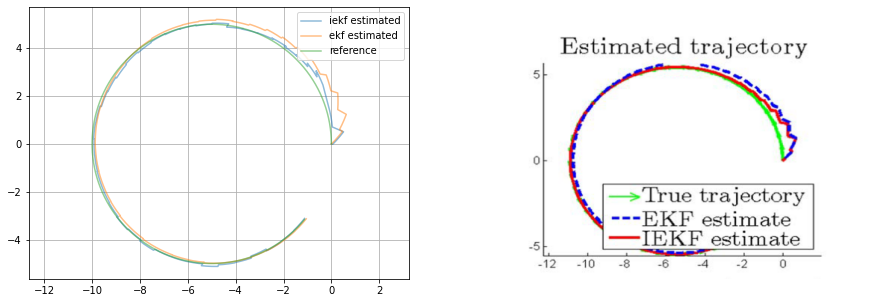

In [10]:
figure(figsize=(15,5))
subplot(121)
plot(xe[:, 1], xe[:, 2], label='iekf estimated', alpha=0.5)
plot(ekf_xe[:, 1], ekf_xe[:, 2], label='ekf estimated', alpha=0.5)
plot(x[:, 1], x[:, 2], label = 'reference', alpha=0.5)
#plot(ekf_x[:, 1], ekf_x[:, 2], label = 'reference', alpha=0.5)
legend(loc=1)
grid()
axis('equal');
subplot(122)
imshow(imread('./images/fig1.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 2

(-0.5, 509.5, 413.5, -0.5)

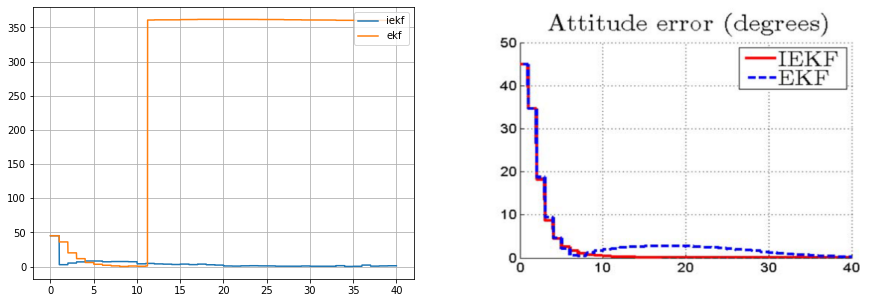

In [11]:
figure(figsize=(15,5))
subplot(121)
err_att = abs(error[:,0]*180/pi)
ekf_err_att = abs(ekf_error[:,0]*180/pi)
plot(t, err_att, label='iekf')
plot(t, ekf_err_att, label='ekf')
legend(loc=1)
grid()
subplot(122)
imshow(imread('./images/fig2.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 3

In [12]:
err = sqrt(error[:,1]**2+error[:,2]**2)
ekf_err = sqrt(ekf_error[:,1]**2+ekf_error[:,2]**2)

(-0.5, 509.5, 413.5, -0.5)

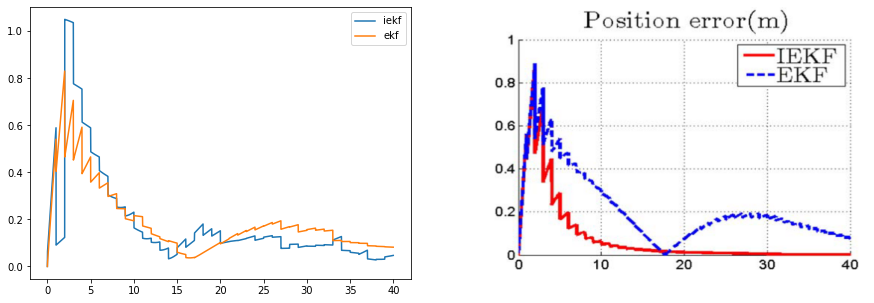

In [13]:
figure(figsize=(15,5))
subplot(121)
plot(t, err, label='iekf')
plot(t, ekf_err, label='ekf')
legend(loc=1)
subplot(122)
imshow(imread('./images/fig3.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [24]:
tf = 40
v = 0.7
r = 5
omega = v /r

vt = array([omega, v, 0])  # velocity, omega
x0 = array([pi/2, 0, 0])
xh0 = array([pi/180+pi/2, 0, 0]) # initial error
P0 = diag([(1*pi/180)**2, 0.1, 0.1])
dt = 0.01
t, xe, x, error, ekf_xe, ekf_x, ekf_error = iekf(tf, vt, x0, P0, dt, xh0)

# Figure 4

(-0.5, 387.5, 317.5, -0.5)

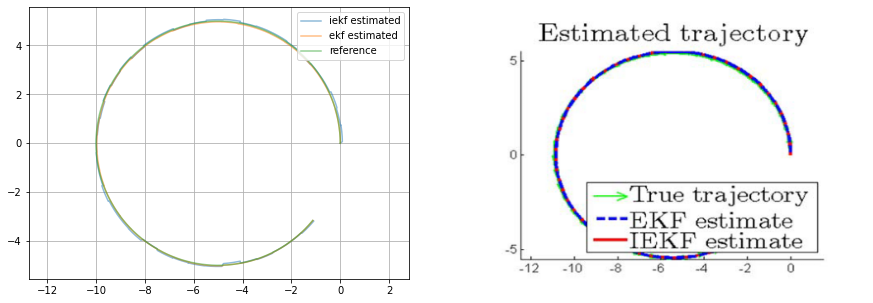

In [31]:
figure(figsize=(15,5))
subplot(121)
plot(xe[:, 1], xe[:, 2], label='iekf estimated', alpha=0.5)
plot(ekf_xe[:, 1], ekf_xe[:, 2], label='ekf estimated', alpha=0.5)
plot(x[:, 1], x[:, 2], label = 'reference', alpha=0.5)
#plot(ekf_x[:, 1], ekf_x[:, 2], label = 'reference', alpha=0.5)
legend(loc=1)
grid()
axis('equal');
subplot(122)
imshow(imread('./images/fig4.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 5

(-0.5, 435.5, 341.5, -0.5)

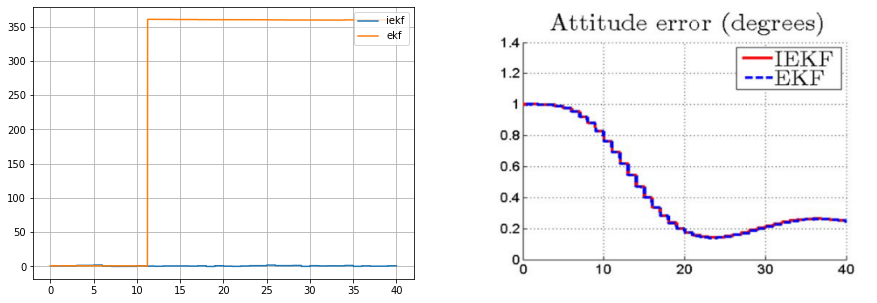

In [30]:
figure(figsize=(15,5))
subplot(121)
err_att = abs(error[:,0]*180/pi)
ekf_err_att = abs(ekf_error[:,0]*180/pi)
plot(t, err_att, label='iekf')
plot(t, ekf_err_att, label='ekf')
legend(loc=1)
grid()
subplot(122)
imshow(imread('./images/fig5.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 6

In [32]:
err = sqrt(error[:,1]**2+error[:,2]**2)
ekf_err = sqrt(ekf_error[:,1]**2+ekf_error[:,2]**2)

(-0.5, 435.5, 341.5, -0.5)

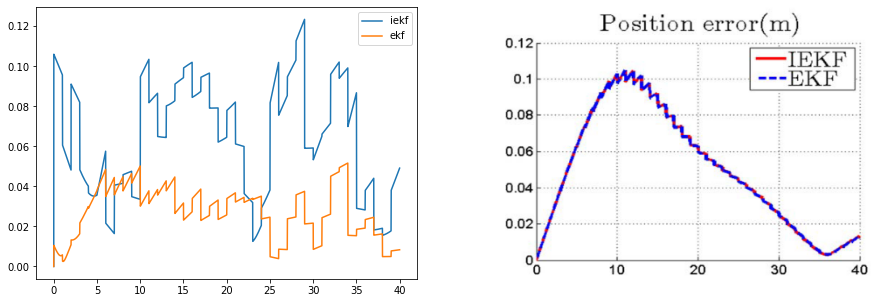

In [33]:
figure(figsize=(15,5))
subplot(121)
plot(t, err, label='iekf')
plot(t, ekf_err, label='ekf')
legend(loc=1)
subplot(122)
imshow(imread('./images/fig6.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [270]:
def ekf(tf, vt, x0, P0, dt, xh0):
    
    # Inital Condition
    P = P0  # covariance in Lie Algebra
    Q = diag([(pi/180)**2,1e-4,1e-4])
    n_steps = int(tf/dt)  # number of steps
    N = 0.01*eye(2)
    H = array([[0, 1, 0],
               [0, 0, 1]])
    e = x0 - xh0
    x = x0
    x_h = xh0
        
    # output data for plotting
    
    for i in range(n_steps):
        
        # store data
        out_ekf_xe.append(x_h)
        out_ekf_x.append(x)
        out_ekf_e.append(e)
        
        # Propagate reference
        dx = array([vt[0], cos(e_x[0])*vt[1], sin(x[0])*vt[1]])
        x = x + dx*dt

        # Propagate estimate error
        de = F@e
        e = e + de*dt
        e_x_h = e_x_h + array([vt[0], cos(e_x_h[0])*vt[1], sin(e_x_h[0])*vt[1]])*dt

        #Propagate Covariance
        P = P + (F@P + P@F.T + Q)*dt

        # Measurement at 100 Hz
        if i%100 == 0:                
            #iekf Gain
            Vn = np.random.multivariate_normal(zeros(2), N)
            S = H@P@H.T + N
            Ln = P@H.T@inv(S) # Gain
            Lnr = Ln@[[1, 0, 0],[0, 1, 0]]

            e = e + Ln@(Vn - H@e)
            x_h = x - e
            # Covariance Measurement Update
            P = (eye(3) - Ln@H)@P
   
    xe = np.array(out_ekf_xe)
    x = np.array(out_ekf_x)
    e = np.array(out_ekf_e)
    return xe, x, e 